# EDA

In [1]:
import os, sys
import math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

os.chdir("..")

In [2]:
raw_parquet = Path("data/raw/orange_belgium_std.parquet")

df = pd.read_parquet(raw_parquet)

df.shape

(11896, 180)

### 1. Общая информация + проверка на пропуски

In [3]:
df.info()

missing = df.isna().mean().sort_values(ascending=False)
print("\nTOП-15 признаков с пропущенными значениями:")
display(missing.head(15))

df.describe().T.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11896 entries, 0 to 11895
Columns: 180 entries, PC1 to churn
dtypes: float64(160), int64(2), object(18)
memory usage: 16.3+ MB

TOП-15 признаков с пропущенными значениями:


PC1     0.0
PC2     0.0
PC3     0.0
PC4     0.0
PC5     0.0
PC6     0.0
PC7     0.0
PC8     0.0
PC9     0.0
PC10    0.0
PC11    0.0
PC12    0.0
PC13    0.0
PC14    0.0
PC15    0.0
dtype: float64

,count,mean,std,min,25%,50%,75%,max
PC1,11896.0,-1.529076e-16,4.267859,-5.855730,-2.683973,-0.768513,1.863594,220.628916
PC2,11896.0,2.293615e-16,3.592514,-244.310395,-1.826691,-0.226555,1.657906,12.598163
PC3,11896.0,-1.013013e-15,3.050609,-46.009928,-1.868285,0.277591,2.041518,20.669144
PC4,11896.0,1.529076e-15,2.503449,-26.008773,-1.267834,-0.121383,0.933916,51.810483
PC5,11896.0,1.854005e-15,2.319435,-30.497294,-0.966924,0.140574,1.295623,10.458377
PC6,11896.0,6.689710e-16,2.195335,-26.924715,-0.984001,-0.131502,0.977795,20.829799
PC7,11896.0,-1.161142e-15,2.105114,-26.729742,-0.955997,-0.008114,0.933733,46.925114
PC8,11896.0,-9.365594e-16,1.919104,-23.567153,-1.294886,0.233207,1.170869,23.120699
PC9,11896.0,3.535989e-15,1.905616,-17.121020,-1.239305,-0.058754,1.247016,13.336972
PC10,11896.0,3.631557e-16,1.842393,-6.996830,-1.193163,-0.242149,0.904046,13.973020


### 2. Проверяем баланс классов

In [4]:
print("Баланс целевой переменной:\n", df['churn'].value_counts(normalize=True).rename({0:'stay',1:'churn'}))
print("\nБаланс контрольных групп:\n", df['treatment'].value_counts(normalize=True).rename({0:'control',1:'target'}))

Баланс целевой переменной:
 churn
stay     0.965703
churn    0.034297
Name: proportion, dtype: float64

Баланс контрольных групп:
 treatment
target     0.757397
control    0.242603
Name: proportion, dtype: float64


Дисбаланс по целевым классам - огромный, учитывая это:
- При обучении будем использовать параметр **class_weight='balanced'** + можно попробовать **SMOTE/undersampling**;
- При оценке используем метрики - ROC-AUC, Precision/Recall, F1 для класса 1;
- При интерпретации важно понимать, что ошибки на churn=1 "стоят дороже".

### 3. "Авто‑сводка" по всем фичам

Создадим табличку с топовыми признаками: будем ориентироваться по "сигналу". Для числовых переменных - разница в средних значениях по каждому классу, если она большая - признак ведет себя по-разному в отношении целевой переменной. Для категориальных - считаем доли ушедших, если разница между долями внутри одной переменной большая - признак потенциально полезен.

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ("churn", "treatment")]
cat_cols = [c for c in df.columns if c not in num_cols + ["churn", "treatment"]]

report = [] 

for col in df.columns:
    if col in ("churn", "treatment"):
        continue
    
    s = df[col]
    n_unique = s.nunique(dropna=True)           # сколько уникальных значений у признака
    miss = float(s.isna().mean())               # доля пропусков

    if pd.api.types.is_numeric_dtype(s):
        # Для числовых грубо меряем "сигнал к таргету":
        # разницу средних при churn=1 и churn=0 (чем больше, тем сильнее сдвиг между классами)
        mean0 = df.loc[df.churn == 0, col].mean()
        mean1 = df.loc[df.churn == 1, col].mean()
        diff = abs(mean1 - mean0)
        report.append([col, "num", n_unique, miss, diff])
    else:
        # Для категориальных берём дисперсию churn-рейта по категориям
        # (если у разных уровней категории сильно разный churn — признак потенциально полезный)
        churn_by_level = df.groupby(col)["churn"].mean()
        churn_var = float(churn_by_level.var()) if len(churn_by_level) > 1 else 0.0
        report.append([col, "cat", n_unique, miss, churn_var])

# Формируем единую таблицу со "сигналом"
eda_table = pd.DataFrame(report, columns=[
    "feature", "type", "n_unique", "missing_rate", "churn_signal"
])

# Топ-15 
display(eda_table.sort_values("churn_signal", ascending=False).head(15))

# Сохраним в отчёты
Path("reports").mkdir(parents=True, exist_ok=True)
eda_table.to_csv("reports/eda_summary.csv", index=False)


,feature,type,n_unique,missing_rate,churn_signal
0,PC1,num,11896,0.0,0.990342
13,PC14,num,11896,0.0,0.348447
21,PC22,num,11896,0.0,0.322867
14,PC15,num,11896,0.0,0.309024
10,PC11,num,11896,0.0,0.299094
5,PC6,num,11896,0.0,0.292340
52,PC53,num,11896,0.0,0.278475
11,PC12,num,11896,0.0,0.257701
7,PC8,num,11896,0.0,0.248501
46,PC47,num,11896,0.0,0.237271


### 4. Корреляция с целевой переменной

In [6]:
num_cols_with_target = num_cols + ["churn"]

corrs = (df[num_cols_with_target]
         .corr(numeric_only=True)['churn']
         .drop('churn') 
         .sort_values(key=abs, ascending=False))

display(corrs.head(15))



PC53    -0.055799
PC22    -0.045386
PC47    -0.044404
PC1      0.042232
PC14     0.041739
PC15    -0.037835
PC76     0.034158
PC31     0.034082
PC11    -0.032238
PC12     0.029681
PC20     0.027644
PC111   -0.026693
PC51    -0.026461
PC17    -0.026413
PC18    -0.026300
Name: churn, dtype: float64

При проверке корреляции числовых признаков с целевой переменной **churn** видно, что самые сильные коэффициенты находятся на уровне ~0.04–0.05. Это очень слабая линейная связь, то есть прямых «мощных сигналов» в данных нет. Для модели это означает, что простые методы (например, линейная регрессия) дадут слабые результаты. Однако бустинги и другие нелинейные модели смогут использовать комбинации признаков, поэтому даже слабые индивидуальные корреляции могут быть полезны в совокупности.

### 5. Оценка среднего эффекта воздействия (глобальный uplift)

In [7]:
# Частота churn в каждой группе: control (0) vs target (1)
tc = pd.crosstab(df['treatment'], df['churn'], normalize='index')
display(tc)

# z-тест
from math import sqrt

p_t = df.loc[df.treatment == 1, 'churn'].mean()  # доля churn в treatment
p_c = df.loc[df.treatment == 0, 'churn'].mean()  # доля churn в control
n_t = (df.treatment == 1).sum()
n_c = (df.treatment == 0).sum()

p_pool = (p_t*n_t + p_c*n_c) / (n_t + n_c)        # объединённая пропорция
se = sqrt(p_pool*(1 - p_pool) * (1/n_t + 1/n_c))  # стандартная ошибка
z = (p_t - p_c)/se if se > 0 else np.nan

print(f"churn_treat={p_t:.4f}, churn_ctrl={p_c:.4f}, diff={p_t - p_c:.4f}, z≈{z:.2f}")


churn,0,1
treatment,,
0,0.963617,0.036383
1,0.966371,0.033629


churn_treat=0.0336, churn_ctrl=0.0364, diff=-0.0028, z≈-0.71


Мы сравнили долю оттока в контрольной и тестовой группе. Разница оказалась минимальной (-0.28%) и статистически незначимой (z≈-0.71). Это означает, что в среднем маркетинговое воздействие не даёт эффекта на отток. Однако это не исключает, что существуют подгруппы клиентов, для которых эффект есть. Поэтому далее мы будем строить uplift-модели, чтобы выявить сегменты, где акция действительно работает.

### 6. Визуализируем ТОП-3 числовых и категориальных признаков

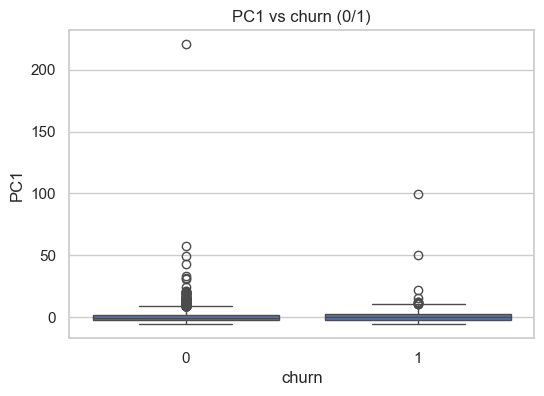

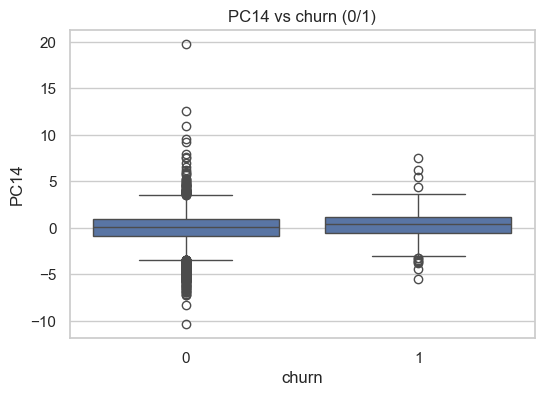

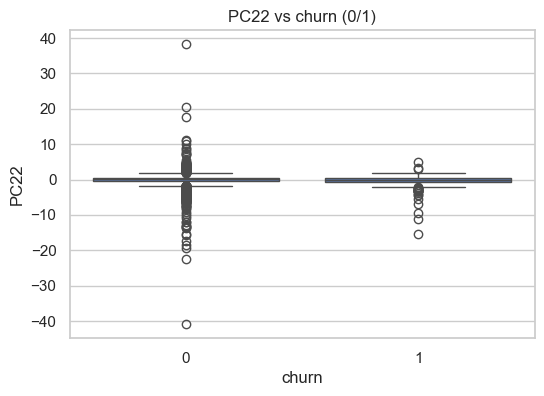

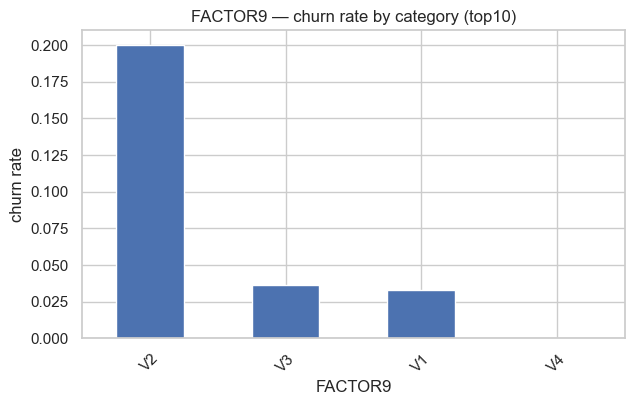

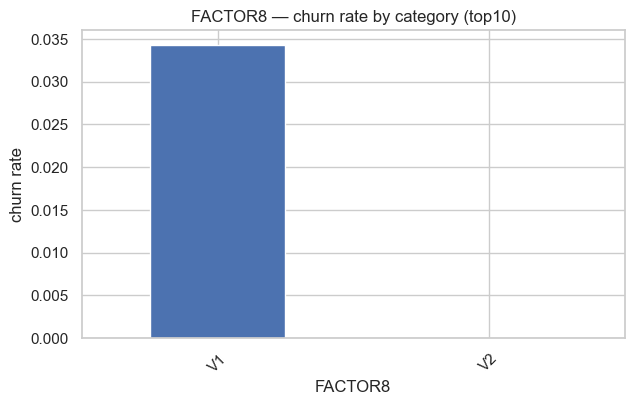

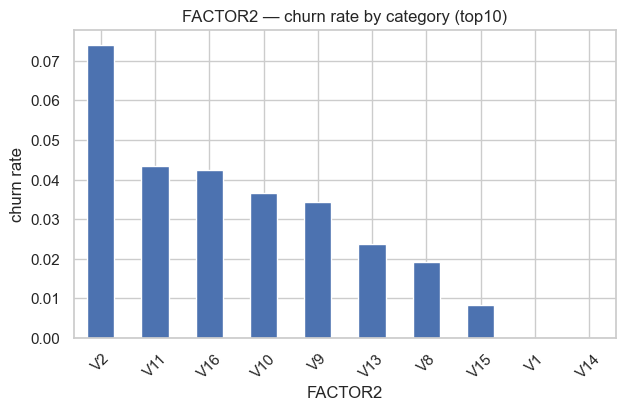

In [ ]:
# Берём 3 самых "сигнальных" числовых и 3 категориальных из сводной таблицы
top_num = (eda_table.query("type=='num'")
           .sort_values("churn_signal", ascending=False)
           .head(3)['feature'])
top_cat = (eda_table.query("type=='cat'")
           .sort_values("churn_signal", ascending=False)
           .head(3)['feature'])

# Числовые: boxplot, чтобы увидеть сдвиг распределений между churn=0 и churn=1
for c in top_num:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df['churn'], y=df[c])
    plt.title(f"{c} vs churn (0/1)")
    plt.show()

# Категориальные: bar churn-рейта для топовых 10 уровней
for c in top_cat:
    ct = pd.crosstab(df[c], df['churn'], normalize='index')
    (ct[1].sort_values(ascending=False).head(10)
        .plot(kind="bar", figsize=(7, 4), rot=45))
    plt.title(f"{c} — churn rate by category (top10)")
    plt.ylabel("churn rate")
    plt.show()


### 7. Визуализируем корреляцию 30 самых "сигнальных" признаков - проверим на мультикорреляционность

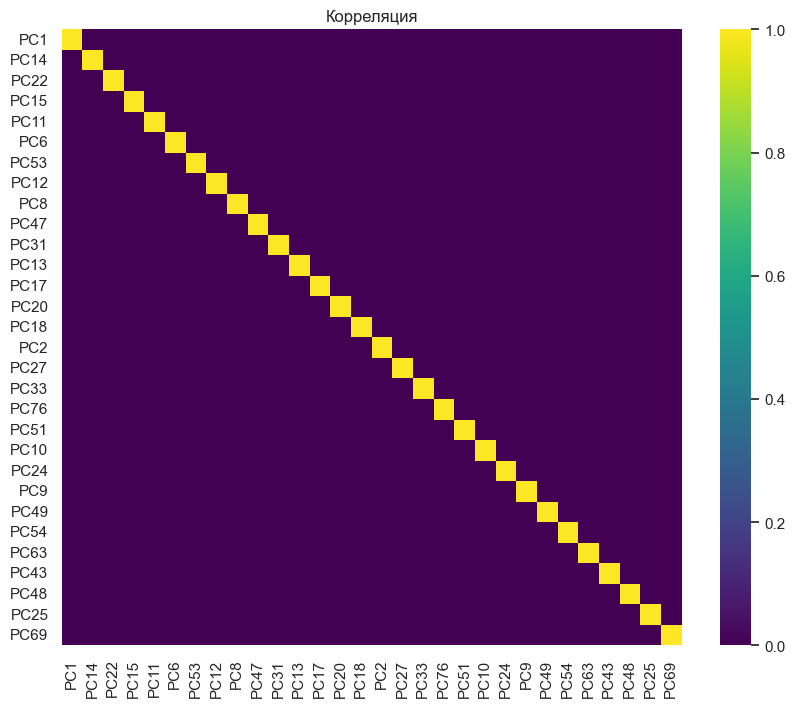

In [9]:
strong_num = (eda_table.query("type=='num'")
              .sort_values("churn_signal", ascending=False)
              .head(30)['feature'].tolist())

corr_mat = df[strong_num].corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, cmap="viridis")
plt.title("Корреляция")
plt.show()


Мы проверили мультиколлинеарность среди 30 самых «сильных» признаков. Почти все корреляции близки к нулю, то есть фичи несут независимую информацию. Это хорошо: значит, нет «дублирующих» признаков, и модель сможет использовать каждую переменную отдельно, без риска переобучения из-за линейных зависимостей.

### 8. Вывод

1. Размер датасета: ~11.9k клиентов и ~180 признаков (PC-фичи + FACTORы).

2. Целевая переменная (churn) сильно несбалансирована: ~3.4% ушедших vs ~96.6% оставшихся. Это значит, что accuracy бесполезна как метрика — будем использовать ROC-AUC, PR-AUC, F1(класс 1) и учитывать class_weight.

3. Treatment/control распределены неравномерно: ~24% control и ~76% target. В среднем churn_rate почти одинаковый (3.64% vs 3.36%, разница -0.28 п.п., z≈-0.71). Значимого среднего эффекта нет - оффер не даёт глобального uplift, эффект возможен только в подгруппах.

**EDA по фичам:**

- Найдены признаки с заметным “сигналом” (например PC1, PC14, PC22, FACTOR9).

- У части категориальных переменных churn-rate сильно отличается по уровням (например, отдельные категории FACTOR9).

- Большинство числовых показывают слабый сдвиг между churn=0 и churn=1.

- Корреляции между признаками: сильных дублей нет.

Итог: глобального эффекта от treatment нет, churn крайне несбалансирован. Есть ряд признаков с сигналом, которые стоит использовать при моделировании.